# Feature engineering

Try different feature engineering techniques to reduce dimensionality of data.

## 0. Import required packages

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from lmfit import Model
from collections import OrderedDict
from sklearn import neighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_regression,f_regression
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.model_selection import cross_val_score
import umap
from sklearn.metrics import make_scorer

pl.style.use('seaborn')
pl.rc('font',family='Arial')

## 1. Baseline model

### 1.1. Read in and shape data

In [2]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")

train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

### 1.2. Train random forest model
Filter for only 24 hr, treated sample. 

In [ ]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)
X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=5)

np.random.seed(999)
forest_model = RandomForestRegressor(max_features=50,n_estimators=100, bootstrap=False,random_state = 999)
forest_model.fit(X_train, Y_train.values.ravel())
Y_pred = forest_model.predict(X_test)

print(forest_model.score(X_test,Y_test))
print(spearmanr(Y_test,Y_pred))

## 2. Test different filtering methods

### 2.1. Drop out by variance in BioRep
General idea: if the variance between bioreps for a single isolate is larger than some threshold for a given gene, that gene may be dominated by noise: drop.

In [3]:
def drop_biorep(X_orig, Y, drop_point):
    reps1 = X_orig[(X_orig['BioRep'] == 1)]
    reps2 = X_orig[(X_orig['BioRep'] == 2)]
    names = []
    for i in range(len(genes)):
        if np.mean(abs(reps2.values[:,i+3] - reps1.values[:,i+3]))/abs(np.max([reps1.values[:,i+3],reps2.values[:,i+3]])) > drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)

    return X_new


In [4]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(0.25,0.75,0.05):
    drop_point = j
    names = []
    for i in range(len(genes)):
        if np.mean(abs(reps2.values[:,i+3] - reps1.values[:,i+3]))/abs(np.max([reps1.values[:,i+3],reps2.values[:,i+3]])) > drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_var = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

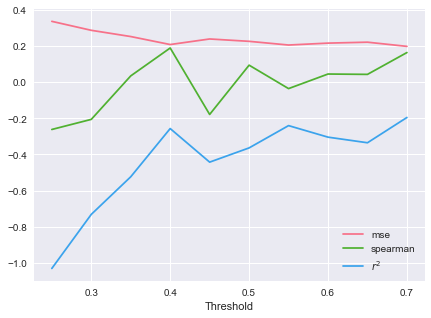

In [59]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_var['threshold'],results_var['mse'])
axes.plot(results_var['threshold'],results_var['spearman'])
axes.plot(results_var['threshold'],results_var['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=4)
axes.set_xlabel('Threshold')

pl.show()

### 2.2. Drop out by cosine similarity of BioReps
General idea: for a given isolate, each biorep should be highly similar for a given gene. If not, drop.

In [6]:
def drop_cosine(X_orig, Y, drop_point):
    reps1 = X_orig[(X_orig['BioRep'] == 1)]
    reps2 = X_orig[(X_orig['BioRep'] == 2)]
    names = []
    for i in range(len(genes)):
        if cosine_similarity(reps2.values[:,i+3].reshape(1, -1),reps1.values[:,i+3].reshape(1, -1))[0][0] < drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)

    return X_new


In [7]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(-0.2,0.95,0.05):
    drop_point = j
    names = []

    for i in range(len(genes)):
        if cosine_similarity(reps2.values[:,i+3].reshape(1, -1),reps1.values[:,i+3].reshape(1, -1))[0][0] < drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_cos = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

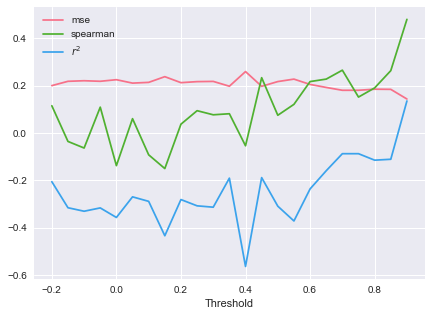

In [33]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_cos['threshold'],results_cos['mse'])
axes.plot(results_cos['threshold'],results_cos['spearman'])
axes.plot(results_cos['threshold'],results_cos['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=2)
axes.set_xlabel('Threshold')

pl.show()

### 2.3. Drop out by cosine similarity of timepoints
General idea: for the untreated samples, the 6 hr and 24 hr timepoints should be similar. If not, drop.

In [12]:
def drop_cosine2(X_orig, Y, drop_point):
    names = []
    sixhr = train_data[(train_data['Timepoint'] == 0)& (train_data['Treatment'] == 0)]
    tfhr = train_data[(train_data['Timepoint'] == 1)& (train_data['Treatment'] == 0)]
    for i in range(len(genes)):
        if cosine_similarity(sixhr.values[:,i+3].reshape(1, -1),tfhr.values[:,i+3].reshape(1, -1))[0][0] < drop_point:
            names.append(genes[i])
    
    X_new = X_orig.drop(names,axis=1)

    return X_new


In [13]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_med = []

for j in np.arange(-0.2,0.95,0.1):
    X_new = drop_cosine2(X_orig, Y, j)

    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_med.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring='neg_median_absolute_error')))
    
results_cos2 = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_med)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_med']) 

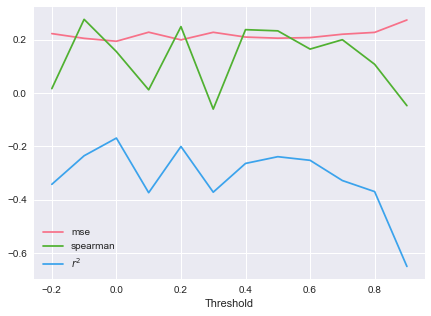

In [35]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_cos2['threshold'],results_cos2['mse'])
axes.plot(results_cos2['threshold'],results_cos2['spearman'])
axes.plot(results_cos2['threshold'],results_cos2['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=3)
axes.set_xlabel('Threshold')

pl.show()

### 2.4. Drop out by correlation coefficient
Drop features with low correlation to the target.

In [15]:
sub = train_data[(train_data['Timepoint'] == 1) & (train_data['Treatment'] == 1)]
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

correlations = sub.corr()

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(0.1,0.55,0.05):
    drop_point = j
    names = list(correlations[abs(correlations['DHA_IC50'])<drop_point].index)
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_cor = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value e

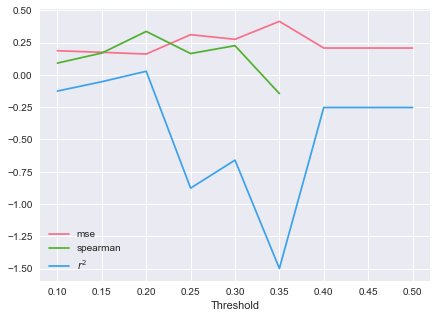

In [37]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_cor['threshold'],results_cor['mse'])
axes.plot(results_cor['threshold'],results_cor['spearman'])
axes.plot(results_cor['threshold'],results_cor['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=3)
axes.set_xlabel('Threshold')

pl.show()

### 2.5. Drop out by Spearman correlation coefficient
Drop features with low Spearman correlation with the target.

In [17]:
sub = train_data[(train_data['Timepoint'] == 1) & (train_data['Treatment'] == 1)]
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

correlations = sub.corr(method='spearman')

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(0.1,0.55,0.05):
    drop_point = j
    names = list(correlations[abs(correlations['DHA_IC50'])<drop_point].index)
    
    X_new = X_orig.drop(names,axis=1)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_scor = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/shasha/miniconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value e

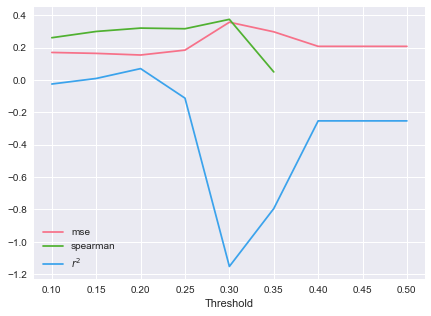

In [39]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_scor['threshold'],results_scor['mse'])
axes.plot(results_scor['threshold'],results_scor['spearman'])
axes.plot(results_scor['threshold'],results_scor['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=3)
axes.set_xlabel('Threshold')

pl.show()

### 2.6. Drop out by MAD
General idea: drop features with low median absolute deviation across all samples. 

In [19]:
def drop_mad(X_orig, Y, components):
    mads = X_orig.mad(axis = 0)
    to_drop = list(mads.sort_values(ascending=True)[:-components].index)
    X_new = X_orig.drop(to_drop,axis=1)

    return X_new

In [22]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

reps1 = X_orig[(X_orig['BioRep'] == 1)]
reps2 = X_orig[(X_orig['BioRep'] == 2)]

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_med = []

for j in np.arange(10,1000,10):
    
    X_new = drop_mad(X_orig,Y,j)
    
    max_features = min(len(X_new.columns),50)
    
    X = StandardScaler().fit_transform(X_new)
    X_train, X_test , Y_train , Y_test = train_test_split(X,Y,test_size=0.33,random_state=33)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))
    cv.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_med.append(np.mean(cross_val_score(forest_model, X_train, Y_train.values.ravel(), cv=5,scoring='neg_median_absolute_error')))
    
results_mad = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_med)),columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_med']) 

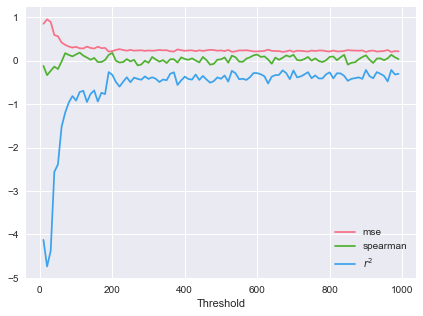

In [40]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_mad['threshold'],results_mad['mse'])
axes.plot(results_mad['threshold'],results_mad['spearman'])
axes.plot(results_mad['threshold'],results_mad['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=4)
axes.set_xlabel('Threshold')

pl.show()

### 2.7. Principle component analysis

In [24]:
def drop_pca(X_orig, Y, components):
    #X_orig.drop(['BioRep'])
    X = StandardScaler().fit_transform(X_orig)
    pca = PCA(n_components=components)
    principalComponents = pca.fit_transform(X)
    X_pca = pd.DataFrame(data = principalComponents)

    return X_pca


In [25]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(5,100,5):
    pca = PCA(n_components=j)
    principalComponents = pca.fit_transform(X)
    X_pca = pd.DataFrame(data = principalComponents)
    
    max_features = min(j,50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_pca,Y,test_size=0.33,random_state=5)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test)
 
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_pca = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

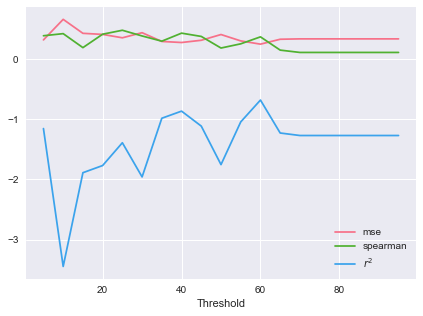

In [42]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_pca['threshold'],results_pca['mse'])
axes.plot(results_pca['threshold'],results_pca['spearman'])
axes.plot(results_pca['threshold'],results_pca['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=4)
axes.set_xlabel('Threshold')

pl.show()

### 2.8. UMAP

In [46]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]

X_new = umap.UMAP().fit_transform(X_orig)
X_new = pd.DataFrame(data=X_new)
X_umap = pd.concat([X_new.reset_index().drop(['index'],axis=1),Y.reset_index().drop(['index'],axis=1)], axis=1)

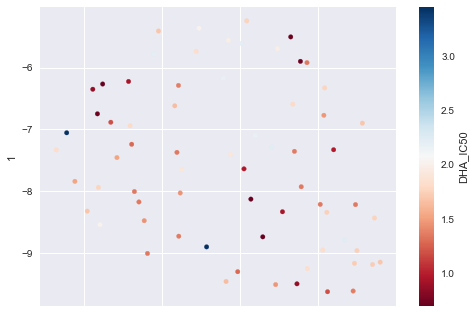

In [53]:
X_umap.plot.scatter(x=0,y=1,c='DHA_IC50',colormap='RdBu')
pl.show()

### 2.9. Univariate f regression

In [48]:
def drop_univ(X_orig, Y, percentile):
    X = StandardScaler().fit_transform(X_orig)
    X_uni = GenericUnivariateSelect(f_regression,'percentile', param=percentile).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    return X_uni

In [49]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(5,70,5):
    X_uni = GenericUnivariateSelect(f_regression,'percentile', param=j).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=5)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_unif = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

/Users/shasha/miniconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/Users/shasha/miniconda3/lib/python3.5/site-packages/sklearn/feature_selection/univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
/Users/shasha/miniconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastruct

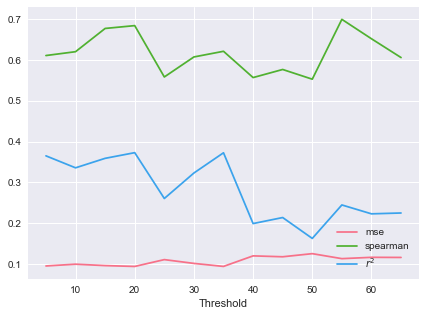

In [55]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_unif['threshold'],results_unif['mse'])
axes.plot(results_unif['threshold'],results_unif['spearman'])
axes.plot(results_unif['threshold'],results_unif['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=4)
axes.set_xlabel('Threshold')

pl.show()

### 2.10. Univariate mutual info regression

In [54]:
X_orig = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','BioRep'], axis=1)
Y = train_data[(train_data['Treatment']==1)&(train_data['Timepoint'] == 1)][['DHA_IC50']]
X = StandardScaler().fit_transform(X_orig)

threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []

for j in np.arange(5,70,5):
    X_uni = GenericUnivariateSelect(mutual_info_regression,'percentile', param=j).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    max_features = min(len(X_uni.columns),50)

    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=5)

    forest_model = RandomForestRegressor(max_features=max_features,n_estimators=100, bootstrap=False,random_state = 999)
    forest_model.fit(X_train, Y_train.values.ravel())
    Y_pred = forest_model.predict(X_test) 
    
    threshold.append(j)
    accuracy.append(forest_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_new.columns))

results_unim = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols)),columns =['threshold', 'accuracy','mse','spearman','num_cols']) 

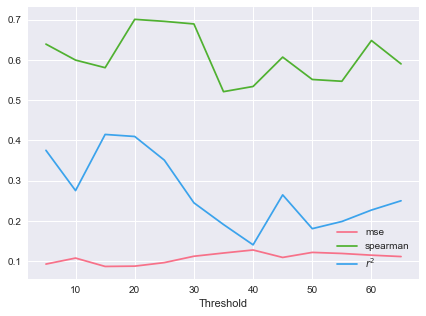

In [56]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.plot(results_unim['threshold'],results_unim['mse'])
axes.plot(results_unim['threshold'],results_unim['spearman'])
axes.plot(results_unim['threshold'],results_unim['accuracy'])
axes.legend(['mse', 'spearman',r'$r^2$'], loc=4)
axes.set_xlabel('Threshold')

pl.show()

## 3. Comparison

In [62]:
methods = pd.DataFrame([['BioRep', np.max(results_var['accuracy']), np.max(results_var['spearman']),np.min(results_var['mse'])], \
                      ['Cos', np.max(results_cos['accuracy']), np.max(results_cos['spearman']),np.min(results_cos['mse'])], \
                      ['Cos2', np.max(results_cos2['accuracy']), np.max(results_cos2['spearman']),np.min(results_cos2['mse'])], \
                      ['Cor',np.max(results_cor['accuracy']), np.max(results_cor['spearman']),np.min(results_cor['mse'])], \
                      ['S Cor', np.max(results_scor['accuracy']), np.max(results_scor['spearman']),np.min(results_scor['mse'])], \
                      ['MAD', np.max(results_mad['accuracy']), np.max(results_mad['spearman']),np.min(results_mad['mse'])], \
                      ['PCA', np.max(results_pca['accuracy']), np.max(results_pca['spearman']),np.min(results_pca['mse'])], \
                      ['Uni F', np.max(results_unif['accuracy']), np.max(results_unif['spearman']),np.min(results_unif['mse'])], \
                      ['Uni M', np.max(results_unim['accuracy']), np.max(results_unim['spearman']),np.min(results_unim['mse'])]])
methods.columns = ['Method', 'Accuracy','Spearman', 'MSE']

In [63]:
methods

,Method,Accuracy,Spearman,MSE
0,BioRep,-0.195597,0.189203,0.198178
1,Cos,0.135075,0.479447,0.143367
2,Cos2,-0.168997,0.275880,0.193769
3,Cor,0.027886,0.336306,0.161134
4,S Cor,0.070168,0.374444,0.154126
5,MAD,-0.214187,0.185241,0.201259
6,PCA,-0.679449,0.481531,0.250381
7,Uni F,0.372667,0.699732,0.093526
8,Uni M,0.414960,0.700724,0.087221


Univariate regression performs best for feature selection according to all metrics.